<i>We take an unorthodox approach to building a spam filter in R, using k-means clustering to filter out spam. The first half will go over the theory behind spam filters and clustering algorithms. The second half will go over what I did to build a spam filter with R. </i>

<!--TEASER_END-->

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Theory" data-toc-modified-id="Theory-1">Theory</a></span><ul class="toc-item"><li><span><a href="#Why-Use-Clustering?" data-toc-modified-id="Why-Use-Clustering?-1.1">Why Use Clustering?</a></span></li><li><span><a href="#How-the-K-Means-Clustering-Algorithms-Works" data-toc-modified-id="How-the-K-Means-Clustering-Algorithms-Works-1.2">How the K-Means Clustering Algorithms Works</a></span></li><li><span><a href="#Vector-Space-and-Normalization" data-toc-modified-id="Vector-Space-and-Normalization-1.3">Vector Space and Normalization</a></span></li></ul></li><li><span><a href="#Creating-A-Spam-Filter" data-toc-modified-id="Creating-A-Spam-Filter-2">Creating A Spam Filter</a></span><ul class="toc-item"><li><span><a href="#The-Data-Set-and-Required-Libraries" data-toc-modified-id="The-Data-Set-and-Required-Libraries-2.1">The Data Set and Required Libraries</a></span></li><li><span><a href="#Overview-of-Methodology" data-toc-modified-id="Overview-of-Methodology-2.2">Overview of Methodology</a></span></li><li><span><a href="#Creating-the-Document-Term-Matrix" data-toc-modified-id="Creating-the-Document-Term-Matrix-2.3">Creating the Document Term Matrix</a></span></li><li><span><a href="#Choosing-the-Number-of-Clusters" data-toc-modified-id="Choosing-the-Number-of-Clusters-2.4">Choosing the Number of Clusters</a></span></li><li><span><a href="#Applying-the--K-Means-Algorithm" data-toc-modified-id="Applying-the--K-Means-Algorithm-2.5">Applying the  K-Means Algorithm</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.6">Results</a></span></li></ul></li><li><span><a href="#test" data-toc-modified-id="test-3">test</a></span></li></ul></div>

# Theory 

## Why Use Clustering?

<p> Research has routinely found naive Bayes classifiers (NBCs) to be the best tool for binary text classification in terms of precision. That is, they identify a high percentage of spam messages with few false positives. So why use the k-means clustering algorithm, when NBCs have been found to be the most precise? There are two main reasons: First, naive Bayes classifiers are incredibly computationally expensive, and as the data set becomes large, you'll find an NBC to be impractically slow. This is why for large data sets, SVM algorithms are generally recommended instead. In contrast, the k-means algorithm is incredibly fast and the computation time scales linearly with the number of data points and features.</p>
<p> Beyond computation time, the k-means algorithm also works incredibly well in conjunction with other models. Research has shown that k-means classifiers stacked with SVMs and NBCs have outperformed SVM and NBC models. </p>

## How the K-Means Clustering Algorithms Works

## Vector Space and Normalization

It's generally a good idea to normalize your data, so that all of your features are fairly represented in your model. The standard way to normalize text data is called text frequency-inverse document frequency. Under this normalization, a word is given more weight based on how frequently it appears in a specific document, and given less weight based on how frequently it across all documents.The specific formula is: 
 
$$TF-IDF(X) = \frac{Number\ of\ times\ X\ appears\ in\ document}{Number\ of\ terms\ in\ document}\ln \frac{Number\ of\ documents}{Number\ of\ documents\ containing\ X} $$

# Creating A Spam Filter

## The Data Set and Required Libraries

<p> For the actual implementation of the spam filter, I will be using the UCI SMS Spam Collection Data Set, available for download <a href="https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection">here</a>. The data set consists of 5574 real, English language text messages.The first column of the data set contains the text of each text, and the second column tells us the classification of the text(spam or legitimate). </p>
<p> Over the course of this project, we will use the following libraries:</p>

In [1]:
library("tm")
library("cluster")
library("caTools")
library("flexclust")
library("factoextra")
library("NbClust")
library("skmeans")
library("textclean")

Loading required package: NLP
Loading required package: grid
Loading required package: lattice
Loading required package: modeltools
Loading required package: stats4
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:NLP’:

    annotate

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


## Overview of Methodology

<p>Going into this project, I knew that my base feature space would be a document term matrix scaled according to term frequency-inverse document frequency, since multiple articles I consulted agreed that this was the most successful feature space for a spam filter. So my first step was to assemble the text messages into a corpus, and process that corpus for analysis (clean the data). For the most part, this was fairly standard; I removed common stop words from my documents, stemmed words, stripped away punctuation and special characters, and converted everything to lowercase letters. The only unusual aspect of my text processing, was that I decided to convert all numbers into their written form (i.e. 1000 becomes one thousand). I did this because numbers are often used as replacement words and phonemes in text messages, and this substitution yielded better classification results. I then converted my processed corpus into the aforementioned document term matrix </p>
<p> Once I had my feature space set up, I tried to use the elbow method to determine the correct number of nodes to use in my model. This method failed for two reasons: my nodes were imbalanced, and there was too much overlap between spam clusters and non-spam clusters (see theory section to understand why). I attempted to solve this by oversampling my spam text messages and removing terms that were high-frequency among both groups.</p>

<p>Finally, in an attempt to boost performance, I tried to integrate additional features into my feature space and I experimented with k-spherical clustering rather than k-means clustering. I then tested my various models on my test data.</p>

## Creating the Document Term Matrix

In [2]:
# Load dataframe and clean up columns
sms = read.csv("spam.csv", stringsAsFactors = F)
sms$X = sms[, 1:2]
colnames(sms) = c("classification", "text")
sms$text = sapply(sms$text, function(x) iconv(enc2utf8(x), sub = "byte")) #remove emoji
sms$classification = ifelse(sms$classification == "spam", 1, 0)

<p> There are multiple valid ways to create a feature space for a spam filter (n-grams, word blocks, text data), but a simple document-term matrix has been shown to be very effective for spam filters.</p>
<p> In order to create a document-term matrix, you should first assemble all of your documents into a corpus (the text messages in this case). You should then process the text in your corpus so that the terms in your corpus are in a more useful form. There is no universally correct way to process your text data, and how you go about processing your corpus will depend on your own knowledge of the situation. That said, it is fairly standard to convert all characters to lowercase characters and to stem words, so that words like "Running" and "run" are treated the same way. Furthermore it is common to remove very common words from your document(stop words) as well as special characters. Again, this all hinges on the situation, and you may choose to do something else, like convert "@" to "at" if you know that's a common substitution. In my case, I will be converting numbers to their written form, since I know numbers are often used as words in text messages. </p>

<p> I used the "tm" library to process my text, which has its own library of common stop words and suffixes, and many built in functions that make processing text easy:</p>

In [3]:
#convert numbers and symbols to written form
sms$text = replace_number(sms$text)  #convert numbers to written form
#sms$text = replace_symbol(sms$text)
# create corpus and process text
corpus = Corpus(VectorSource(sms$text))
corpus = tm_map(corpus, tolower)
corpus = tm_map(corpus, removePunctuation)
corpus = tm_map(corpus, stripWhitespace)
corpus = tm_map(corpus, removeWords, stopwords("english"))
corpus = tm_map(corpus, stemDocument)
corpus = tm_map(corpus, removeNumbers)

<i> *Here I used tm's list of English stopwords, but if you have time, I encourage you to experiment with your own list of stopwords.</i>

<p> Once I have processed my text, I will convert my corpus into a DTM (document-term matrix) that is weighted according to TfIdf(term frequency-inverse document frequency). I will then remove terms that are too sparse in order to prevent over-fitting and cut down on computation time. In this case I have decided to remove terms that appear in fewer than 2% of documents.</p>

In [4]:
dtm = DocumentTermMatrix(corpus, control= list(weighting=weightTfIdf)) #create document term matrix
spdtm = removeSparseTerms(dtm, 0.985) #remove sparse terms
spdtm

Warning message in weighting(x):
“empty document(s): 287 960 1195 1273 1319 1394 1427 1483 1553 1700 1925 2182 2322 2509 2660 3050 3155 3375 3491 3614 3832 3916 4013 4497 4574 4823 4855 4858 5269 5358”

<<DocumentTermMatrix (documents: 5572, terms: 99)>>
Non-/sparse entries: 18537/533091
Sparsity           : 97%
Maximal term length: 8
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)

<p> And convert that sparse DTM into a data frame</p>

In [5]:
Sparse = as.data.frame(as.matrix(spdtm))
colnames(Sparse) = make.names(colnames(Sparse))
Sparse$classification = sms$classification

<p> Finally, I remove words from my data frame that frequently occur in both spam and non-spam messages, since these words won't help with classification. To do this I created individual DTMs for spam and non-spam subsets, and compared the most frequent words in each class. </p>

In [6]:
#Term frequency table for spam messages
SpamCorpus = Corpus(VectorSource(sms$text[sms$classification == 1]))
SpamCorpus = tm_map(SpamCorpus, tolower)
SpamCorpus = tm_map(SpamCorpus, removePunctuation)
SpamCorpus = tm_map(SpamCorpus, stripWhitespace)
SpamCorpus = tm_map(SpamCorpus, removeWords, stopwords("english"))
SpamCorpus = tm_map(SpamCorpus, stemDocument)
SpamCorpus = tm_map(SpamCorpus, removeNumbers)
SpamDTM = DocumentTermMatrix(SpamCorpus)
SpamSDTM = removeSparseTerms(SpamDTM, 0.92) #remove sparse terms
SpamFrequency = sort(colSums(as.matrix(SpamSDTM)))
SpamFrequency = data.frame(term = names(SpamFrequency), frequency = SpamFrequency)


In [7]:
#Term frequency table for non-spam messages
HamCorpus = Corpus(VectorSource(sms$text[sms$classification == 0]))
HamCorpus = tm_map(HamCorpus, tolower)
HamCorpus = tm_map(HamCorpus, removePunctuation)
HamCorpus = tm_map(HamCorpus, stripWhitespace)
HamCorpus = tm_map(HamCorpus, removeWords, stopwords("english"))
HamCorpus = tm_map(HamCorpus, stemDocument)
HamCorpus = tm_map(HamCorpus, removeNumbers)
HamDTM = DocumentTermMatrix(HamCorpus)
HamSDTM = removeSparseTerms(HamDTM, 0.97) #remove sparse terms
HamFrequency = sort(colSums(as.matrix(HamSDTM)))
HamFrequency = data.frame(term = names(HamFrequency), frequency = HamFrequency)

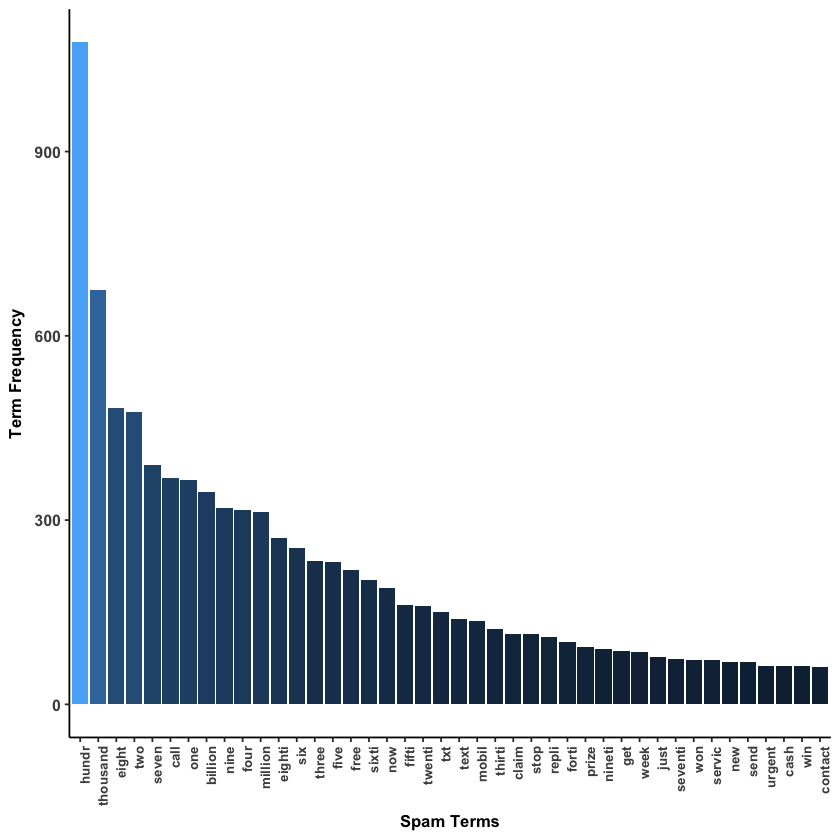

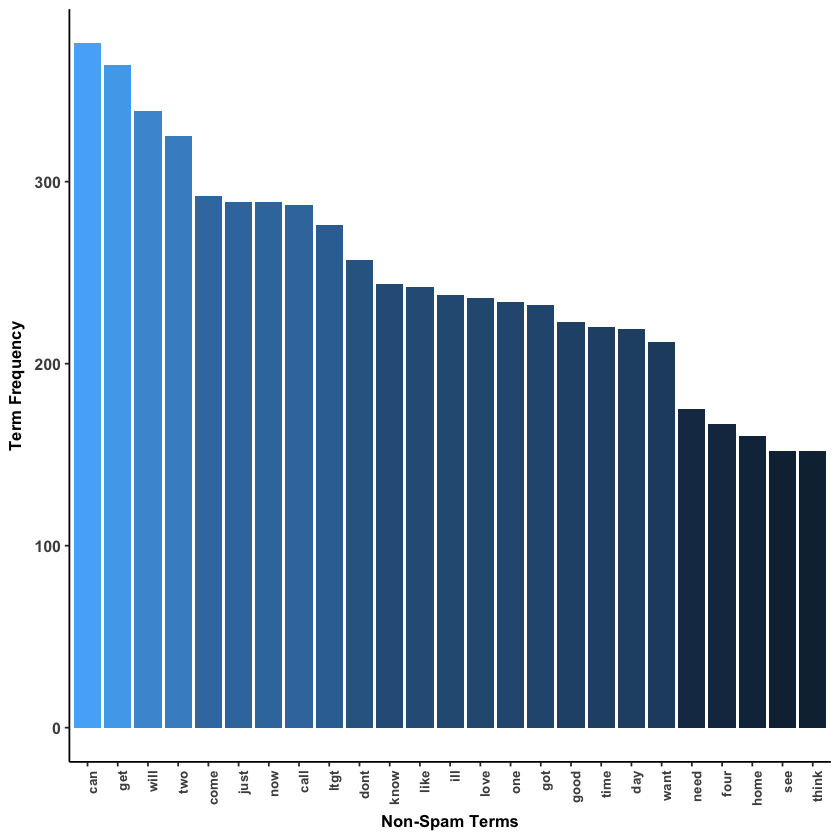

In [8]:
#Word Frequency Graphs
ggplot(SpamFrequency, aes(x = reorder(term, -frequency), y = frequency, fill = frequency))+
  geom_bar(stat = "identity")+theme_classic()+
  theme(text = element_text(size = 12, face = "bold"),
      axis.title = element_text(size = 10), 
      axis.text.x = element_text(angle = 90, hjust = 1, size = 8),
      legend.position = "none")+xlab("Spam Terms")+ylab("Term Frequency")

ggplot(HamFrequency, aes(x = reorder(term, -frequency), y = frequency, fill = frequency))+
  geom_bar(stat = "identity")+theme_classic()+
  theme(text = element_text(size = 12, face = "bold"),
      axis.title = element_text(size = 10), 
      axis.text.x = element_text(angle = 90, hjust = 1, size = 8),
      legend.position = "none")+xlab("Non-Spam Terms")+ylab("Term Frequency")

<p> Looking at our graphs, we can see that there are actually very few terms that are frequently used in both text messages and spam messages. It's also interesting to note that numbers seem to be the most commonly used terms in spam messages, while "two" and "four" are the only frequently used numbers in non-spam messages. In retrospect, this makes sense, since most spam texts I have received contain links and codes.</p>

<p> Now we can remove the terms that are common to spam and non-spam messages from our original DTM, and move on to the next step in creating our spam filter. </p>

In [9]:
#Remove common words from original DTM
common = intersect(HamFrequency$term, SpamFrequency$term)
common
Sparse = Sparse[, !(names(Sparse) %in% common)]

[1] "four" "one"  "call" "just" "now"  "two"  "get"

In [ ]:
Sparse$two=NULL
Sparse$call=NULL
Sparse$now=NULL
Sparse$four=NULL

## Choosing the Number of Clusters

<p> Choosing the correct number of clusters is an incredibly important aspect of using the k-means algorithm, as choosing the wrong number of clusters will have dramatic effects on the accuracy of your model. Determining the correct number of clusters for a given data set is actually a very difficult question to answer mathematically, and the topic of a lot of research. In this case, because of our feature knowledge, we expect the correct number of clusters to be two, but since it is not always possible to know the correct number of clusters going into the problem, we will explore a few commonly used methods for determining the optimal number of clusters that you can read about <a href="http://www.sthda.com/english/wiki/determining-the-optimal-number-of-clusters-3-must-known-methods-unsupervised-machine-learning">here</a>. Keep in mind, it is possible for all of these methods to fail; in which case, your data may not be suited to kmeans clustering. </p>

<p> We will first try to determine the optimal number of clusters using the <a href="http://www.sthda.com/english/wiki/determining-the-optimal-number-of-clusters-3-must-known-methods-unsupervised-machine-learning#elbow-method">elbow method</a>. The basic idea behind this method is that the group variance is plotted out for N clusters. As the number of clusters increases, you should see an inflection point, i.e. a point where we see the curve of the graph flatten out. The point should look like the bend of an arm.</p>

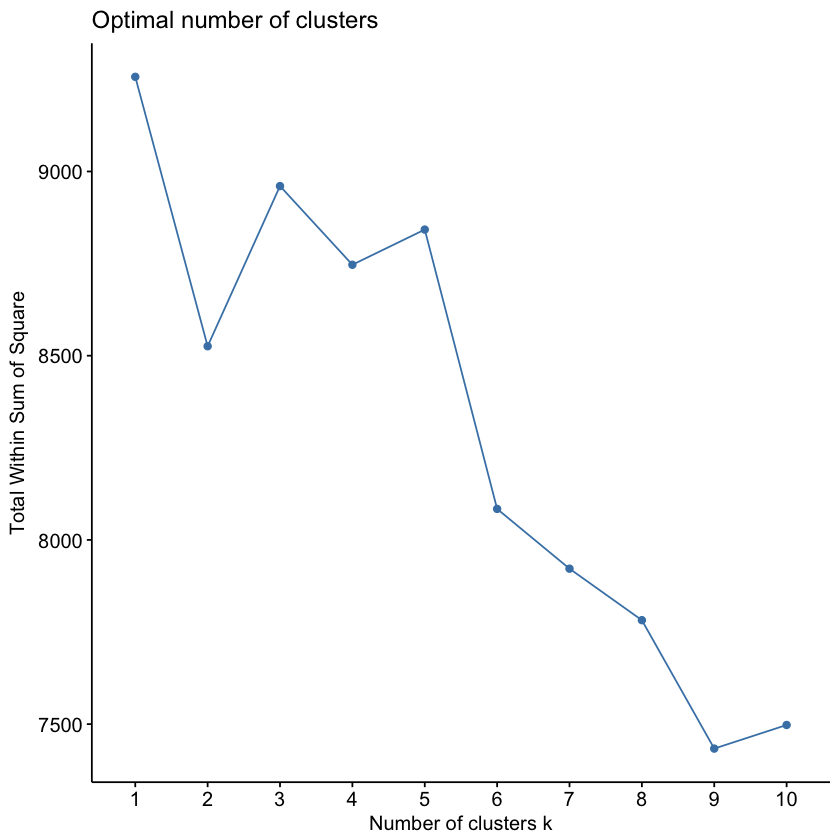

In [10]:
fviz_nbclust(Sparse, kmeans, method = "wss")

<p> Here we see the elbow method produces inconclusive results, which means that our data fails to conform to the assumptions the algorithm makes. Either the clusters aren't spherical enough, the clusters are too unequal in size (number of occurrences), or the clusters are too unequal in variance (radius). Looking at a profile of our data bellow, it appears that the natural clusters are too oblong for the elbow method.</p>

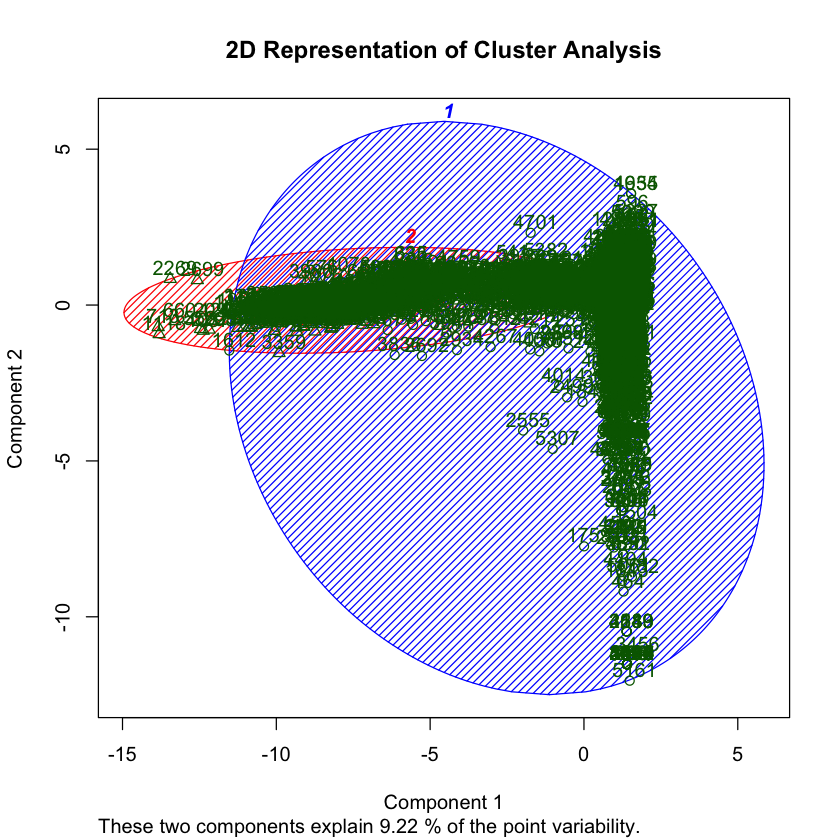

In [15]:
kmeans=kmeans(Sparse[, !(names(Sparse) %in% "classification")], 2, iter.max = 100, nstart=100)
clusplot(Sparse, kmeans$cluster, main = "2D Representation of Cluster Analysis", color=T, shade=T, labels=2, lines=0)

<p> So we will move on to the silhouette method, which suggests 2 clusters as the optimal number of clusters.</p>

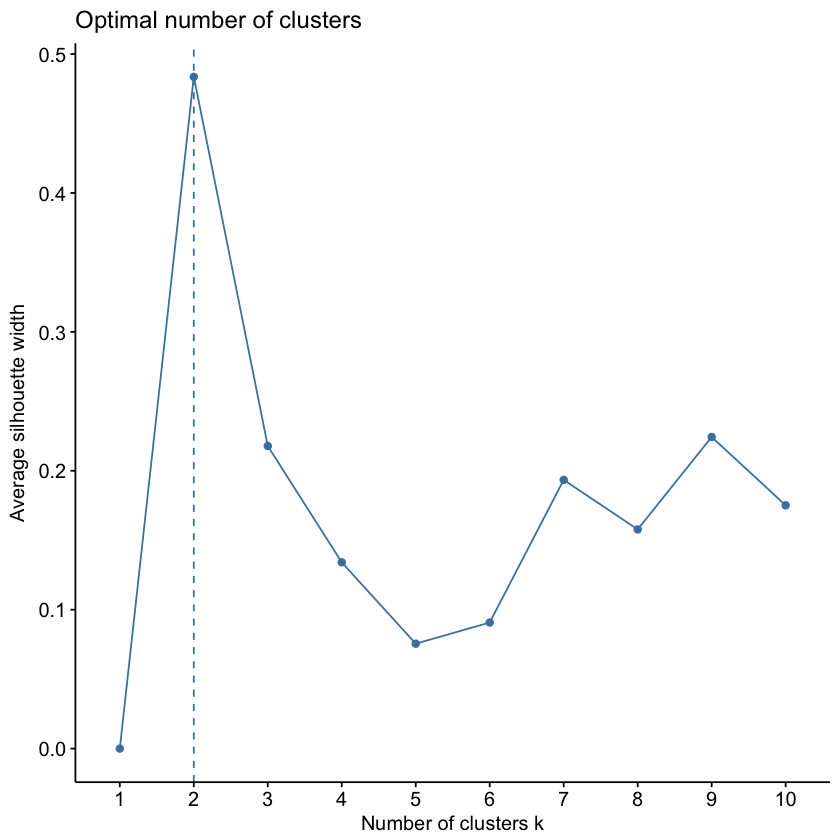

In [10]:
fviz_nbclust(Sparse, kmeans, method = "silhouette")


## Applying the  K-Means Algorithm

<p> Now that we know the correct number of clusters, we have all the tools we need to run a k-means clustering algorithm. In order to do that, we should split our data into a training set and a test set. I will opt for a 75/25 split. </p>

In [18]:
set.seed(144)
split = sample.split(Sparse$got, SplitRatio = 0.75)
train = subset(Sparse, split == TRUE)
test = subset(Sparse, split == FALSE)

<p> Then I build my model on my training data, excluding the classification column. Since the data set is small, I can use a large number of iterations and starting configurations.</p>

In [19]:
kmeans = kmeans(train[, !(names(train) %in% "classification")], 2, iter.max = 100, nstart = 100)

<p> And then I fit the messages in my test data to the clusters built in the previous step using the predict function in the flexclust library </p>

In [20]:
kmc.kcca = as.kcca(kmeans, train[, !(names(train) %in% "classification")])
prediction = predict(kmc.kcca, newdata = test[, !(names(test) %in% "classification")])

## Results 

<p> In order to determine the accuracy of my model, I append the cluster labels to my training and test data. </p>

In [21]:
train$cluster=kmeans$cluster
test$cluster = prediction

<p> Then I create a confusion matrix for my training data. I will label the cluster with the most spam the spam cluster. </p>

In [22]:
table(train$classification, train$cluster)
SpamTable=tapply(train$classification, train$cluster, mean)[tapply(train$classification, train$cluster, mean)>0.7]
SpamClusters=subset(train, train$cluster %in% names(SpamTable))

   
       1    2
  0    0 3610
  1  573    0

<p> Here we see that our model accurately classified all spam messages together into cluster 1 and all non-spam messages together in cluster 1. (This actually makes me very nervous, since this is a red flag for an over-fitted model). </p>
<p> Now we build our confusion matrix for our testing data, keeping in mind that any messages in cluster 1 would be classified as spam.</p>

In [23]:
table(test$classification, test$cluster)

   
       1    2
  0    0 1215
  1  174    0

<p> And again we see that the messages have been accurately grouped into the correct cluster. </p>

<p> Hopefully this post gives you an idea of how to prepare text data for a machine learning algorithm, and how to use the k-means algorithm for classification problems. I may do something similar in the future, where I experiment with different feature selection methods, or different clustering algorithms. </p>

# test